## Uno Cards Color Detection


In [25]:
import glob
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### 1. Load dataset

Load the images found in `DATASET/*`.
Analyze the filename to extract the label for each image.

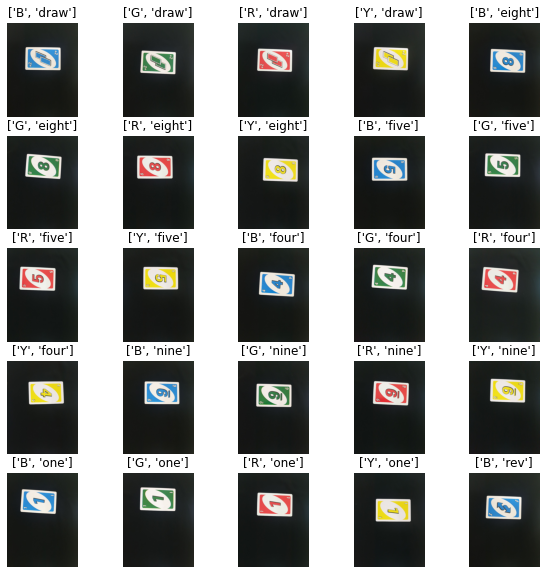

In [26]:
# Load the dataset
images = []
labels = []

for fn in glob.glob("DATASET/*"):
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get the filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension


 
  # The second part is the color (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 2. Crop out card

An edge detection is performed to find the cards in the image. This is done with an adaptive threshold which is the best method to have a fast and lighting robust edge detection.  The inner contour is picked as the card contour. This contour must also have a minimal area so that noise is not picked up. The contour is approximated with an oriented bounding box (OBB). The four corner points are then used to perform a perspective transform, to reorient and crop the card image.

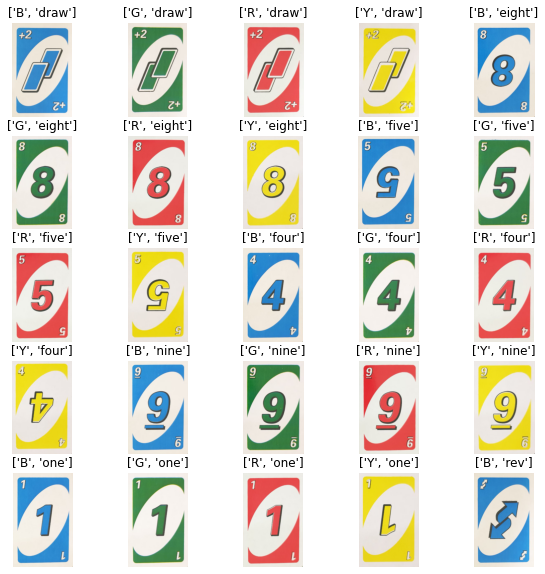

In [27]:
# Find region of interest (ROI) for each image
for i in range(len(images)):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  # there is a large area around
  # the uno card.
  # apply dilatation
  # to close any contour AND when cropping, make
  # sure that we don't get anything outside the card

  # When finding the contours, we get two contours
  # around the card. We pick the most inner one.
  # The dilatation process will make sure the inner
  # contour is exclusively inside the card

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=10)

  # Find biggest external contour 
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  idx_biggest = np.argmax([cv.contourArea(c) for c in contours])
  idx_inner = hierarchy[0][idx_biggest][2]
  cnt = contours[idx_inner]


  # Find oriented bounding box around card
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)

  # Have the most top-left first, and also 
  # the contour should be clockwise from the 
  # previous functions
  idx_leftop = np.argmin([p[0]+p[1] for p in box])
  box_ordered = []
  for j in range(4):
    box_ordered.append(box[(idx_leftop+j)%4])
  box = np.array(box_ordered)


  box_l11 = np.linalg.norm(box[0]-box[1])
  box_l12 = np.linalg.norm(box[2]-box[3])

  box_l21 = np.linalg.norm(box[1]-box[2])
  box_l22 = np.linalg.norm(box[3]-box[0])

  box_l1 = (box_l11+box_l12)/2
  box_l2 = (box_l21+box_l22)/2

  # Card is straight
  new_width, new_height = None, None
  if box_l1 < box_l2:
    new_points = np.array([
      [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
    new_width = box_l1
    new_height = box_l2

  # Card is on its side
  else:
    new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
    new_width = box_l2
    new_height = box_l1

  # Compute perspective transform matrix and get wrapped
  # image which is only the card
  M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
  roi = cv.warpPerspective(images[i], M, (round(new_width), round(new_height)))

  images[i] = roi

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 3. Split the dataset into training and testing

Split the dataset into training and testing 80% / 20% 

In [28]:
# Do testing for color
# Take a 80% train and 20% test proportion
indices = list(range(len(images)))
random.shuffle(indices)

train_indices = indices[:int(len(images)*0.8)]
test_indices = indices[int(len(images)*0.8):]

print("TRAIN: ", train_indices)
print("TEST: ", test_indices)

TRAIN:  [36, 22, 27, 8, 21, 39, 31, 16, 19, 11, 20, 9, 48, 2, 7, 14, 32, 0, 29, 5, 12, 24, 40, 26, 42, 13, 43, 46, 17, 10, 38, 34, 28, 23, 33, 30, 47, 6, 50, 1, 15]
TEST:  [3, 4, 51, 45, 49, 41, 44, 18, 25, 37, 35]


### 4. Color detection on training

#### 4.1 Convert image to HSV
##### The images were converted to HSV colour space

The HSV color space is more robust to lighting conditions. The image is also resized to speed up color detection.

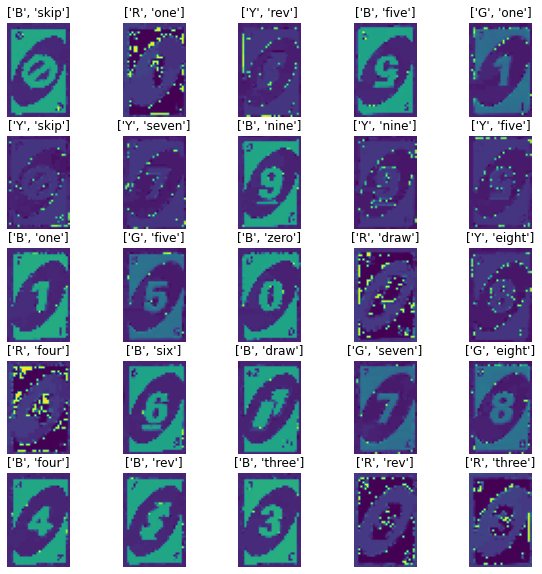

In [29]:
CARD_SMALL_WIDTH = 30
CARD_RATIO = 1.5
CARD_SMALL_HEIGHT = round(CARD_SMALL_WIDTH*CARD_RATIO)
hue_images = []

for i in train_indices:
  small = cv.resize(images[i], (CARD_SMALL_WIDTH, CARD_SMALL_HEIGHT), interpolation=cv.INTER_NEAREST)
  small_hsv = cv.cvtColor(small, cv.COLOR_BGR2HSV)
  hue_image = small_hsv[:,:,0]
  hue_images.append(hue_image)
    
# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(hue_images[i])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 4.2 Count pixels in range
##### For each UNO colour, the number of pixels in the range were counted.


* The ranges are fixed values. Count for each image, the number of pixels in those ranges. Each range correspond to an ideal UNO color.

* The result is a 4-component vector


In [30]:
color_ranges = [
  [100, 105],
  [65, 75],
  [0, 5],
  [25, 30]
]

comps = []

for ii, i in enumerate(train_indices):
  comp = []
  for j in range(4):
    th = cv.inRange(hue_images[ii], color_ranges[j][0], color_ranges[j][1])
    comp.append(cv.countNonZero(th))
  comp = np.array(comp)
  comps.append(comp)
    
for i in range(25):
  print(str(labels[train_indices[i]]), comps[i])

['B', 'skip'] [562   5   2  23]
['R', 'one'] [  0   9 424 465]
['Y', 'rev'] [  0   0  19 583]
['B', 'five'] [533  10   8  28]
['G', 'one'] [  2 202  19  23]
['Y', 'skip'] [  1   0  17 614]
['Y', 'seven'] [  0   0  17 539]
['B', 'nine'] [521   4   5  16]
['Y', 'nine'] [  0   0  22 564]
['Y', 'five'] [  2   0   9 554]
['B', 'one'] [493   7   6  25]
['G', 'five'] [  0 386  16  43]
['B', 'zero'] [516   5   9  19]
['R', 'draw'] [  0   8 500 427]
['Y', 'eight'] [  0   2  22 551]
['R', 'four'] [  0   7 427 400]
['B', 'six'] [520  10   8  24]
['B', 'draw'] [551   5   3  26]
['G', 'seven'] [  0 269  21  38]
['G', 'eight'] [  3 442  15  52]
['B', 'four'] [497   1   3  23]
['B', 'rev'] [530   4   6  22]
['B', 'three'] [498   3   4  23]
['R', 'rev'] [  0   1 518 507]
['R', 'three'] [  0  13 478 256]


### 5. Test against testing data

#### The test dataset, was then tested against the training dataset

1.	Find 4-component vector as explained above
2.	The 4-component vector were compared with train dataset 4-component vector
3.	The closest hue 4-component vector in train dataset was picked
4.	Make sure that train and test label for the colour match

In [33]:
good, bad = 0, 0
for i in test_indices:
  small = cv.resize(images[i], (CARD_SMALL_WIDTH, CARD_SMALL_HEIGHT), interpolation=cv.INTER_NEAREST)
  small_hsv = cv.cvtColor(small, cv.COLOR_BGR2HSV)
  # Pick hue channel
  hue_image = small_hsv[:,:,0]
  
  # Count number of pixels for each range
  comp = []
  for j in range(4):
    th = cv.inRange(hue_image, color_ranges[j][0], color_ranges[j][1])
    comp.append(cv.countNonZero(th))

  comp = np.array(comp)

  
  closest_idx = np.argmin([np.linalg.norm(c - comp) for c in comps])
  closest_idx = train_indices[closest_idx]

  if labels[closest_idx][0] == labels[i][0]:
    good += 1
  else:
    bad += 1


print(f"Color testing: GOOD {good}/BAD {bad}/TOTAL {good+bad}")

Color testing: GOOD 11/BAD 0/TOTAL 11
